Threshold and Subject-level Accuracy Analysis on RNAseq data

Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann, F Krastev

The main objective of the notebook is to simulate the variation for a given subject at different levels of relative standard deviation (RSD) of Transcripts Per Million (TPM) and then to demonstrate how the score varies.

We have three main outputs from the notebook.
Output 1: Scatter plot showing the simulated classifier scores vs the original classifier scores for all subjects.
Output 2: File containing the subject-wise accuracy by calculating number of simulations that fall in FP and FN for a subject at a given threshold for further analysis.
Output 3: File containing the False Positives, False Negatives, True Positives and True Negatives across 243 subjects at a given %RSD for further analysis.
Output 4: v-plot od classifier scores vs accuracies (agreement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
myDF = pd.read_excel("/anvil/projects/tdm/corporate/molecular-stethoscope/data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 1)
# setting index row name to the gene id
myDF = myDF.set_index('gene_id')
myDF2 = pd.read_excel("/anvil/projects/tdm/corporate/molecular-stethoscope/data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 0)

In [2]:
# len(myDF.columns)

Step 1: Data prep

In [3]:
#Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
Patients_df = myDF[~myDF.loc[:,'Coeff'].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(Patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
Patients_df = Patients_df.filter(regex='^\d+')

In [4]:
#Patients_df

In [5]:
#filter the replicate you want to use
Patient_r1= Patients_df.filter(regex= 'r1')
len(Patient_r1.columns)

243

In [6]:
def rename_col(x):
    x = x.split('-')[0]
    return x


In [7]:
Patient_r1= Patient_r1.rename(columns= rename_col)

In [8]:
Patient_r1.head()

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5666,5668,5669,5672,5673,5683,5702,5706,5767,5784
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000079482.12,40.167869,43.221009,102.123100,59.941767,72.000992,68.009413,36.429882,23.048952,42.758910,324.773646,...,7.241628,29.941308,12.028422,12.210246,14.666869,43.060290,299.701309,13.634830,12.370367,10.735082
ENSG00000169021.5,4.669515,8.401576,6.827512,11.148535,5.426358,9.386716,9.091259,13.298815,11.476520,10.141916,...,9.157797,9.033823,11.104957,10.812369,12.342026,9.796506,7.469338,9.483267,17.178199,11.460425
ENSG00000204160.11,91.808686,52.448546,105.386495,32.223227,29.494519,71.504342,29.258033,135.617663,154.684557,64.057872,...,21.998621,32.591081,28.522205,41.586849,37.958158,51.737799,33.142251,53.717439,55.816251,58.390142
ENSG00000106780.8,44.561230,8.633877,19.836541,9.518698,9.937019,13.294896,10.621600,43.468393,53.064115,15.950573,...,6.930561,2.426163,13.022023,9.901631,7.649485,4.687122,3.887344,15.858130,12.566394,15.729589
ENSG00000113303.11,3.803395,2.503695,10.826006,7.922817,5.855945,8.926236,12.333506,10.168998,18.504409,4.763099,...,10.451834,1.889500,3.506828,0.000000,2.506974,7.199588,0.000000,5.215797,0.804744,4.051561


In [51]:

patient_id= list(Patient_r1.columns.values)
patient_id= list(map(int,patient_id))
#patient_id

In [52]:
#Patient_r1.drop(Patient_r1["11182"]<= 10, inplace = True)

In [53]:
# # group columns by patient id
# grouped_cols = Patients_df.columns.str.split('-').str[0]

# # group columns by patient id and r1/r2 suffixes
# grouped = Patients_df.groupby(grouped_cols, axis=1)

# # apply the mean function to the r1 and r2 columns for each group
# # taking mean of the replicates for subjects with multiple replicates
# Patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# #Patients_df.head()

Step 2: Computing Zscores and RSD from TPM data

In [54]:


Patient_r1['Mean']= Patient_r1.mean(axis=1)
Patient_r1['Std']=Patient_r1.iloc[:,:-1].std(axis=1)
Patient_r1['RSD'] = (Patient_r1['Std'] / Patient_r1['Mean'])*100 # New code Filip

Patient_r1.head()
#print(Patients_df.shape)

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5672,5673,5683,5702,5706,5767,5784,Mean,Std,RSD
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000079482.12,40.167869,43.221009,102.123100,59.941767,72.000992,68.009413,36.429882,23.048952,42.758910,324.773646,...,12.210246,14.666869,43.060290,299.701309,13.634830,12.370367,10.735082,59.766894,91.602606,153.266467
ENSG00000169021.5,4.669515,8.401576,6.827512,11.148535,5.426358,9.386716,9.091259,13.298815,11.476520,10.141916,...,10.812369,12.342026,9.796506,7.469338,9.483267,17.178199,11.460425,10.732954,3.963547,36.928760
ENSG00000204160.11,91.808686,52.448546,105.386495,32.223227,29.494519,71.504342,29.258033,135.617663,154.684557,64.057872,...,41.586849,37.958158,51.737799,33.142251,53.717439,55.816251,58.390142,69.451458,84.591569,121.799558
ENSG00000106780.8,44.561230,8.633877,19.836541,9.518698,9.937019,13.294896,10.621600,43.468393,53.064115,15.950573,...,9.901631,7.649485,4.687122,3.887344,15.858130,12.566394,15.729589,16.585846,21.546889,129.911305
ENSG00000113303.11,3.803395,2.503695,10.826006,7.922817,5.855945,8.926236,12.333506,10.168998,18.504409,4.763099,...,0.000000,2.506974,7.199588,0.000000,5.215797,0.804744,4.051561,6.195916,7.561014,122.032224


In [55]:
rsd= Patient_r1["RSD"]
rsd= list(rsd)
rsd[0]

153.2664665973042

In [56]:
sum(float(num) >=50  for num in rsd)

715

In [57]:
# We define a function whose input is TPM and outputs the corresponding Zscore
def z_score(x):
    return (x-x['Mean'])/x['Std']

In [58]:
# Computing and storing zscores
Patients_df_zScore = Patient_r1.apply(lambda x: z_score(x), axis=1)
Patients_df_zScore.head()
#print(Patients_df_zScore.shape)

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5672,5673,5683,5702,5706,5767,5784,Mean,Std,RSD
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000079482.12,-0.213957,-0.180627,0.462391,0.001909,0.133556,0.089981,-0.254764,-0.400839,-0.185671,2.893005,...,-0.519163,-0.492344,-0.182381,2.619297,-0.503611,-0.517415,-0.535267,0.0,0.347542,1.020709
ENSG00000169021.5,-1.529801,-0.588205,-0.985340,0.104851,-1.338850,-0.339655,-0.414198,0.647365,0.187601,-0.149118,...,0.020036,0.405968,-0.236265,-0.823408,-0.315295,1.626131,0.183541,0.0,-1.707917,6.609183
ENSG00000204160.11,0.264296,-0.201000,0.424806,-0.440094,-0.472351,0.024268,-0.475147,0.782184,1.007584,-0.063760,...,-0.329402,-0.372298,-0.209402,-0.429230,-0.186000,-0.161189,-0.130761,0.0,0.178979,0.618834
ENSG00000106780.8,1.298349,-0.369054,0.150866,-0.327989,-0.308575,-0.152734,-0.276803,1.247630,1.692971,-0.029483,...,-0.310217,-0.414740,-0.552225,-0.589343,-0.033774,-0.186544,-0.039739,0.0,0.230244,5.259481
ENSG00000113303.11,-0.316429,-0.488323,0.612364,0.228395,-0.044964,0.361105,0.811742,0.525469,1.627889,-0.189501,...,-0.819456,-0.487890,0.132743,-0.819456,-0.129628,-0.713022,-0.283607,0.0,0.180544,15.320207


In [59]:
Patient_r1= Patient_r1.set_index([ 'Mean', 'Std', 'RSD'])    
Patient_r1.head()

,,,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5666,5668,5669,5672,5673,5683,5702,5706,5767,5784
Mean,Std,RSD,,,,,,,,,,,,,,,,,,,,,
59.766894,91.602606,153.266467,40.167869,43.221009,102.123100,59.941767,72.000992,68.009413,36.429882,23.048952,42.758910,324.773646,...,7.241628,29.941308,12.028422,12.210246,14.666869,43.060290,299.701309,13.634830,12.370367,10.735082
10.732954,3.963547,36.928760,4.669515,8.401576,6.827512,11.148535,5.426358,9.386716,9.091259,13.298815,11.476520,10.141916,...,9.157797,9.033823,11.104957,10.812369,12.342026,9.796506,7.469338,9.483267,17.178199,11.460425
69.451458,84.591569,121.799558,91.808686,52.448546,105.386495,32.223227,29.494519,71.504342,29.258033,135.617663,154.684557,64.057872,...,21.998621,32.591081,28.522205,41.586849,37.958158,51.737799,33.142251,53.717439,55.816251,58.390142
16.585846,21.546889,129.911305,44.561230,8.633877,19.836541,9.518698,9.937019,13.294896,10.621600,43.468393,53.064115,15.950573,...,6.930561,2.426163,13.022023,9.901631,7.649485,4.687122,3.887344,15.858130,12.566394,15.729589
6.195916,7.561014,122.032224,3.803395,2.503695,10.826006,7.922817,5.855945,8.926236,12.333506,10.168998,18.504409,4.763099,...,10.451834,1.889500,3.506828,0.000000,2.506974,7.199588,0.000000,5.215797,0.804744,4.051561


In [60]:
#Patient_r1.to_csv('R2_data.csv')

Step 3: Defining Monte Carlo simulation and classifier functions using RSD

In [61]:
#np.random.seed(46215423)

#SImulation using gene-specific RSD
def RSD_simulation(subject, rsd, coefficient):
    score=0
    subject_list = list(subject)
    for i in range (len(subject_list)):
        std= rsd[i]/100 * subject_list[i]
        std = np.abs(std)
        sum_number= (coefficients[i]) * int(np.random.normal(subject_list[i], std, size=1))
        score= score+ sum_number
    return(score)
        
# Sampling function performing the Monte Carlo simulations
def Simulation(means, rsd, coefficients):
    std= [rsd/100 * val for val in means]
    std = np.abs(std)
    return np.sum(np.multiply(coefficients, np.random.normal(means, std, size=(1, len(coefficients)))))

# Function to perform anti-logit operation on the linear score 
def cl_score(linear_score, gamma = 0):
    temp = gamma + linear_score
    classifier_score = np.exp(temp) / (1 + np.exp(temp))
    return classifier_score

# Function to calculate subject wise mean and rsd of simulated scores 
def run_sim_one_patient_mean_sd(col):
    temp_Sim = [RSD_simulation(col, rsd, coefficients) for _ in range(numRuns)]
    return [np.mean(temp_Sim),np.std(temp_Sim)]

# Function to calculate the classifier score for each simulation of "num_runs" simulations, corresponding to each subject
def run_sim_one_patient(col, num_runs):
    temp_Sim = np.asarray([cl_score(RSD_simulation(col, rsd, coefficients)) for _ in range(num_runs)])
    return temp_Sim

# This score is the classifer linear score we want to compare with the simulated scores
def linear_score(coefficients, col):
    linear_score = np.sum(coefficients * col, axis=0)
    return linear_score

Step 4: (Hyperparameters) We decide on number of simulations per subject (num_runs), assumed variation on TPM counts (uncertainty), and a classification threshold (thresh) ---¶ num_runs is the number of scores we will generate per patient, each score is generated by choosing a TPM value from a normal distribution that has the actual value as mean (or the average of the TPM counts if there are replicates) and rsd determined by the variable 'uncertainty'.

In [62]:
num_runs = 1
uncertainty = 25
thresh = 0.04874941

Step 5: Defining a function that plots the uncertainty around the threshold, and returns the figure, false positive count, false negative count, and number of subjects with unreliable classification for the specified variation and threshold.

In [63]:
def plot_uncert_at_thresh(num_runs, thresh ):
    
    
    """The purpose of this function is to produce 2 things based on %RSD (uncertainty), threshold (thresh), number of MC simulations (num_runs) :
    1. Figure to show the scattering based on classifier scores of simulations against subject.
    2. False Positves/Negatives
    
    pseudocode:
    1.  for a range of %RSD, the code starts with the first %RSD.
    2a. for each subject, it calculates the linear score by multiplying the z-scores present in dataframe "Patients_df_zScore"  by coefficient. Function used: linear_score
    2b. then it performs anti-logit operation on the linear score to get the classifier score.  Function used: cl_score 
    3.  similarly, "scores" stores the classifier score for each simulation of "num_runs"simulations, corresponding to each subject. Function used: run_sim_one_patient
    4a. since, we will plot the simulation scores against the subject scores, x_data creates the same array shape for subject scores as simulation scores.
    4b. y_data is just scores for the simplicity.
    5.  Now coming to each simuation score in each subject: we will sort out the simulation as FP, FN, TP, TN based on threshold using if-else condtions. this code 
        will run for num_runs.
    6.  based on FP, FN, TP, TN we will calculate the accuracy.
    7.  the process 2-6 will be repeated for each subject.
    8.  A scatter plot will be produced using simulation scores on y-axis and subject scores on x-axis, two perpendicular lines passing the thresholds on x and y axis
     will  categorize the scatter dots into FP, FN , TP and TN.
    
    
    Example input: sub_accuracy(400, 50, 0.87)
    """
    
    false_pos = 0 # counter, stores number of points on second quadrant
    false_neg = 0
    num_subj_unreliable = np.zeros(len(Patient_r1.columns)) # keeps track of subjects whose score is unreliable under the assumed variation (0 is fine, 1 is unreliable)
    fig = plt.figure(figsize=(10,10))
    #for i in range(243):
    for i in range(len(Patient_r1.columns)):
        scores = run_sim_one_patient(Patients_df_zScore.iloc[:, i], num_runs)
        y_0 = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, i]))
        x_data = np.ones_like(scores) * y_0
        y_data = scores
        colour = np.zeros_like(x_data)
        for j in range(len(x_data)):
            if x_data[j] > thresh and y_data[j] < thresh:
                colour[j] = 1
                false_neg = false_neg + 1
                num_subj_unreliable[i] = 1
            elif x_data[j] < thresh and y_data[j]> thresh:
                colour[j] = 2
                false_pos = false_pos + 1
                num_subj_unreliable[i] = 1
        plt.scatter(x_data, y_data, c=colour, cmap = 'Dark2_r' ,alpha = 0.15, s=100)
    plt.axvline(x = thresh, color = 'g', linestyle= '--')
    plt.axhline(y = thresh, color = 'g', linestyle= '--')
    #plt.xlim([0.425, 0.575])
    #plt.ylim([0.425, 0.575])
    plt.xlabel("Classifier score", fontsize= 24)
    plt.ylabel("Simulated scores", fontsize = 24)
    plt.title('Uncertainty around threshold', fontsize = 28)
    # Below are the labels of agreement and disagreement
    A = plt.scatter([0],[0], alpha =0) # dummy plot for legend
    B = plt.scatter([0],[0],  alpha =0) # dummy plot for legend
    plt.text(0, 0.8, 'A', fontsize = 20)
    plt.text(0, 0, 'B', fontsize =20)
    plt.text(0.8, 0, 'B', fontsize =20)
    plt.text(0.8, 0.8, 'A', fontsize =20)
    plt.legend([A,B], ['A : Agreement', 'B : Disagreement'])
    #plt.savefig('figures/uncert_around_thresh_25_RSD.png')

    return [ fig , false_pos , false_neg , (np.sum(num_subj_unreliable)) ]


In [64]:
### Check that random seeding is working by running this cell several times... it is working.
np.random.seed(78987765)
scores = run_sim_one_patient(Patients_df_zScore.iloc[:, 67], 10)
sorted(scores)

[5.172028517738868e-05,
 0.00031202036281440947,
 0.0009271429340417615,
 0.000987017001206884,
 0.003605244459712077,
 0.00468327348055105,
 0.004749769783518576,
 0.004779865270705731,
 0.010691952760394176,
 0.012097144941353465]

[<Figure size 720x720 with 1 Axes>, 19, 0, 19.0]

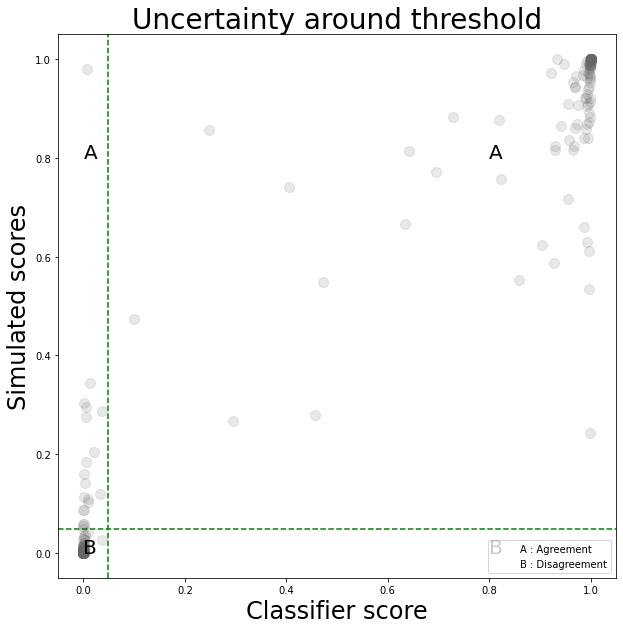

In [65]:
plot_uncert_at_thresh(1, thresh)

In [66]:

def sub_accuracy(thresh, num_runs):
    """The purpose of this function is to calculate 2 things based on %RSD (uncertainty_range), threshold (thresh), number of MC simulations (num_runs) :
    1. subject accuracy based on number of simulations : this info is provided in a dataframe called "accuracy_df"
    2. True Positives/Negatives, False Positves/Negatives: this info is provided in a dtatframe called "false_pos_df"
    
    pseudocode:
    1.  for a range of %RSD, the code starts with the first %RSD.
    2a. for each subject, it calculates the linear score by multiplying the z-scores present in dataframe "Patients_df_zScore"  by coefficient. Function used: linear_score
    2b. then it performs anti-logit operation on the linear score to get the classifier score.  Function used: cl_score 
    3.  similarly, "scores" stores the classifier score for each simulation of "num_runs"simulations, corresponding to each subject. Function used: run_sim_one_patient
    4a. since, we will plot the simulation scores against the subject scores, x_data creates the same array shape for subject scores as simulation scores.
    4b. y_data is just scores for the simplicity.
    5.  Now coming to each simuation score in each subject: we will sort out the simulation as FP, FN, TP, TN based on threshold using if-else condtions. this code will run for num_runs.
    6.  based on FP, FN, TP, TN we will calculate the accuracy.
    7.  the process 2-6 will be repeated for each subject.
    8.  the process 2-7 will be repeated for each %RSD input. 
    
    
    Example input: sub_accuracy([20, 40, 50], 0.87, 400)  -> note that uncertainty_range should be given in a form of a list even if giving single value.
    """
    
    np.random.seed(46215423)
    global real_score
    global accuracy_df
    global y_data
    global x_data
    global Sub_score 
    global false_pos_df
    global fig
    global classification_df
   
    lin_score = np.zeros(len(Patient_r1.columns))
    real_score = np.zeros(len(Patient_r1.columns))
    accuracy = np.zeros(len(Patient_r1.columns))
    classification_series=[]
    false_pos_df = pd.DataFrame( index= ['simulations in agreement with subject', 'simulations in disagreement with subject', 'Unreliable Subjects'])
    
    
    num_subj_unreliable = np.zeros(len(Patient_r1.columns)) # keeps track of subjects whose score is unreliable under the assumed variation (0 is fine, 1 is unreliable)
    false_pos_series=[]
    AD=0
    NCI=0
    Sub_score = pd.Series(real_score)
   
    accuracy_df= pd.DataFrame()
    
    
    FN = []
    FP = []
    TN = []
    TP = []
        
    for j in range(len(Patient_r1.columns)):
        false_pos = 0 # counter, stores number of points on second quadrant
        false_neg = 0
        true_pos = 0
        true_neg = 0
        scores = run_sim_one_patient(Patients_df_zScore.iloc[:, j], num_runs)
        y_0 = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, j]))
        x_data = np.ones_like(scores) * y_0
        y_data = scores
        colour = np.zeros_like(x_data)
        false_neg = 0
        false_pos = 0
        for k in range(len(x_data)):
            if x_data[k] > thresh and y_data[k] < thresh:
                false_neg = false_neg + 1
                num_subj_unreliable[j] = 1
            elif x_data[k] < thresh and y_data[k]> thresh:
                false_pos = false_pos + 1
                num_subj_unreliable[j] = 1
            elif x_data[k]> thresh and y_data[k] > thresh:
                true_pos = true_pos +1
            elif x_data[k] < thresh and y_data[k] < thresh:
                true_neg = true_neg +1  

        accuracy[j] = (num_runs-(false_neg)-(false_pos))/num_runs
        real_score[j] = y_0
        lin_score[j]= linear_score(coefficients, Patients_df_zScore.iloc[:, j])

        FN.append(false_neg)
        FP.append(false_pos)
        TN.append(true_neg)
        TP.append(true_pos)
        unreliable_subjects= str(np.sum(num_subj_unreliable))
        
  
        disagreement = sum(FN) + sum(FP)
        agreement= sum(TN) + sum(TP)
       
        accuracy_df["Accuracy"] = accuracy*100
        false_pos_df["Values"]= [agreement, disagreement, unreliable_subjects]
        Sub_score = pd.Series(real_score)
        lin_subscore = pd.Series(lin_score)
              
        accuracy_df['Classifier Score']= Sub_score
        
    fig = sns.lineplot(x= "Classifier Score" , y="Accuracy", data=accuracy_df, linewidth= 1)
    
    accuracy_df['Subject ID'] = patient_id
    accuracy_df = accuracy_df.set_index('Subject ID')
    
    for l in range (len(Sub_score)):
            if Sub_score[l]>thresh:
                classification_series.append("AD")
                AD= AD+1
            else: 
                NCI =NCI+1
                classification_series.append("NCI")
    classification_df = pd.DataFrame(classification_series)
    classification_df['Linear Score'] = lin_subscore.round(decimals = 5)
    classification_df['Probability']= Sub_score

    
    classification_df['Subject ID']= patient_id
    classification_df= classification_df.set_index('Subject ID')
    classification_df = classification_df.sort_values(by= 'Subject ID', ascending=True)

    return ( print("AD=",AD), print("NCI=",NCI), accuracy_df, false_pos_df, classification_df )
   

AD= 121
NCI= 122


(None,
 None,
             Accuracy  Classifier Score
 Subject ID                            
 11174          100.0          1.000000
 11178            0.0          0.002432
 11182          100.0          0.999244
 11186          100.0          0.994161
 11190          100.0          0.987583
 ...              ...               ...
 5683           100.0          0.000024
 5702           100.0          0.000521
 5706           100.0          0.001245
 5767           100.0          0.000017
 5784           100.0          0.003423
 
 [243 rows x 2 columns],
                                          Values
 simulations in agreement with subject       224
 simulations in disagreement with subject     19
 Unreliable Subjects                        19.0,
               0  Linear Score  Probability
 Subject ID                                
 1817        NCI     -10.07612     0.000042
 1818        NCI      -9.98694     0.000046
 1821        NCI      -8.97744     0.000126
 1850        NCI     -

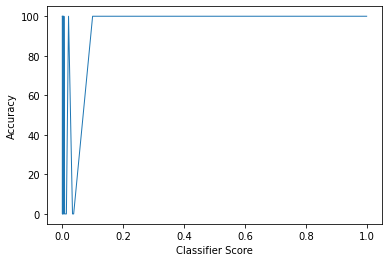

In [67]:
sub_accuracy(thresh, 1)

In [68]:
merge_df = classification_df.merge(myDF2, left_on='Subject ID', right_on = 'Isolate ID')
merge_df= merge_df.set_index('Isolate ID')
merge_df = merge_df.rename(columns={"Disease": "Actual Diagnosis", 0 : "Classifier Diagnosis"})
merge_df.loc[(merge_df['Actual Diagnosis'] == 'NCI') & (merge_df['Classifier Diagnosis'] == 'NCI'), 'Prediction'] = 'TN'  
merge_df.loc[(merge_df['Actual Diagnosis'] == 'AD') & (merge_df['Classifier Diagnosis'] == 'AD'), 'Prediction'] = 'TP' 
merge_df.loc[(merge_df['Actual Diagnosis'] == 'NCI') & (merge_df['Classifier Diagnosis'] == 'AD'), 'Prediction'] = 'FP'
merge_df.loc[(merge_df['Actual Diagnosis'] == 'AD') & (merge_df['Classifier Diagnosis'] == 'NCI'), 'Prediction'] = 'FN'  
merge_df

,Classifier Diagnosis,Linear Score,Probability,Actual Diagnosis,Prediction
Isolate ID,,,,,
1817.0,NCI,-10.07612,0.000042,NCI,TN
1818.0,NCI,-9.98694,0.000046,NCI,TN
1821.0,NCI,-8.97744,0.000126,NCI,TN
1850.0,NCI,-10.66773,0.000023,NCI,TN
1854.0,NCI,-10.88468,0.000019,NCI,TN
...,...,...,...,...,...
17948.0,NCI,-5.90750,0.002712,NCI,TN
17949.0,NCI,-13.56726,0.000001,NCI,TN
17950.0,NCI,-8.70154,0.000166,NCI,TN


In [69]:
prediction = merge_df['Prediction']
pred_list = prediction.to_list()
TN=0
TP=0
FN=0
FP=0
for i in range(len(pred_list)):
    if pred_list[i] == "TN":
        TN=TN+1
        
    elif pred_list[i] == "TP":
        TP=TP+1
        
    elif pred_list[i] == "FN":
        FN=FN+1
        
    else: FP= FP+1
#pred_list


sensitivity= TP/(TP+FN)
specificity= TN/(TN+FP)

print("Specificity:", specificity, " Sensitivity:", sensitivity)

Specificity: 0.9310344827586207  Sensitivity: 0.889763779527559
